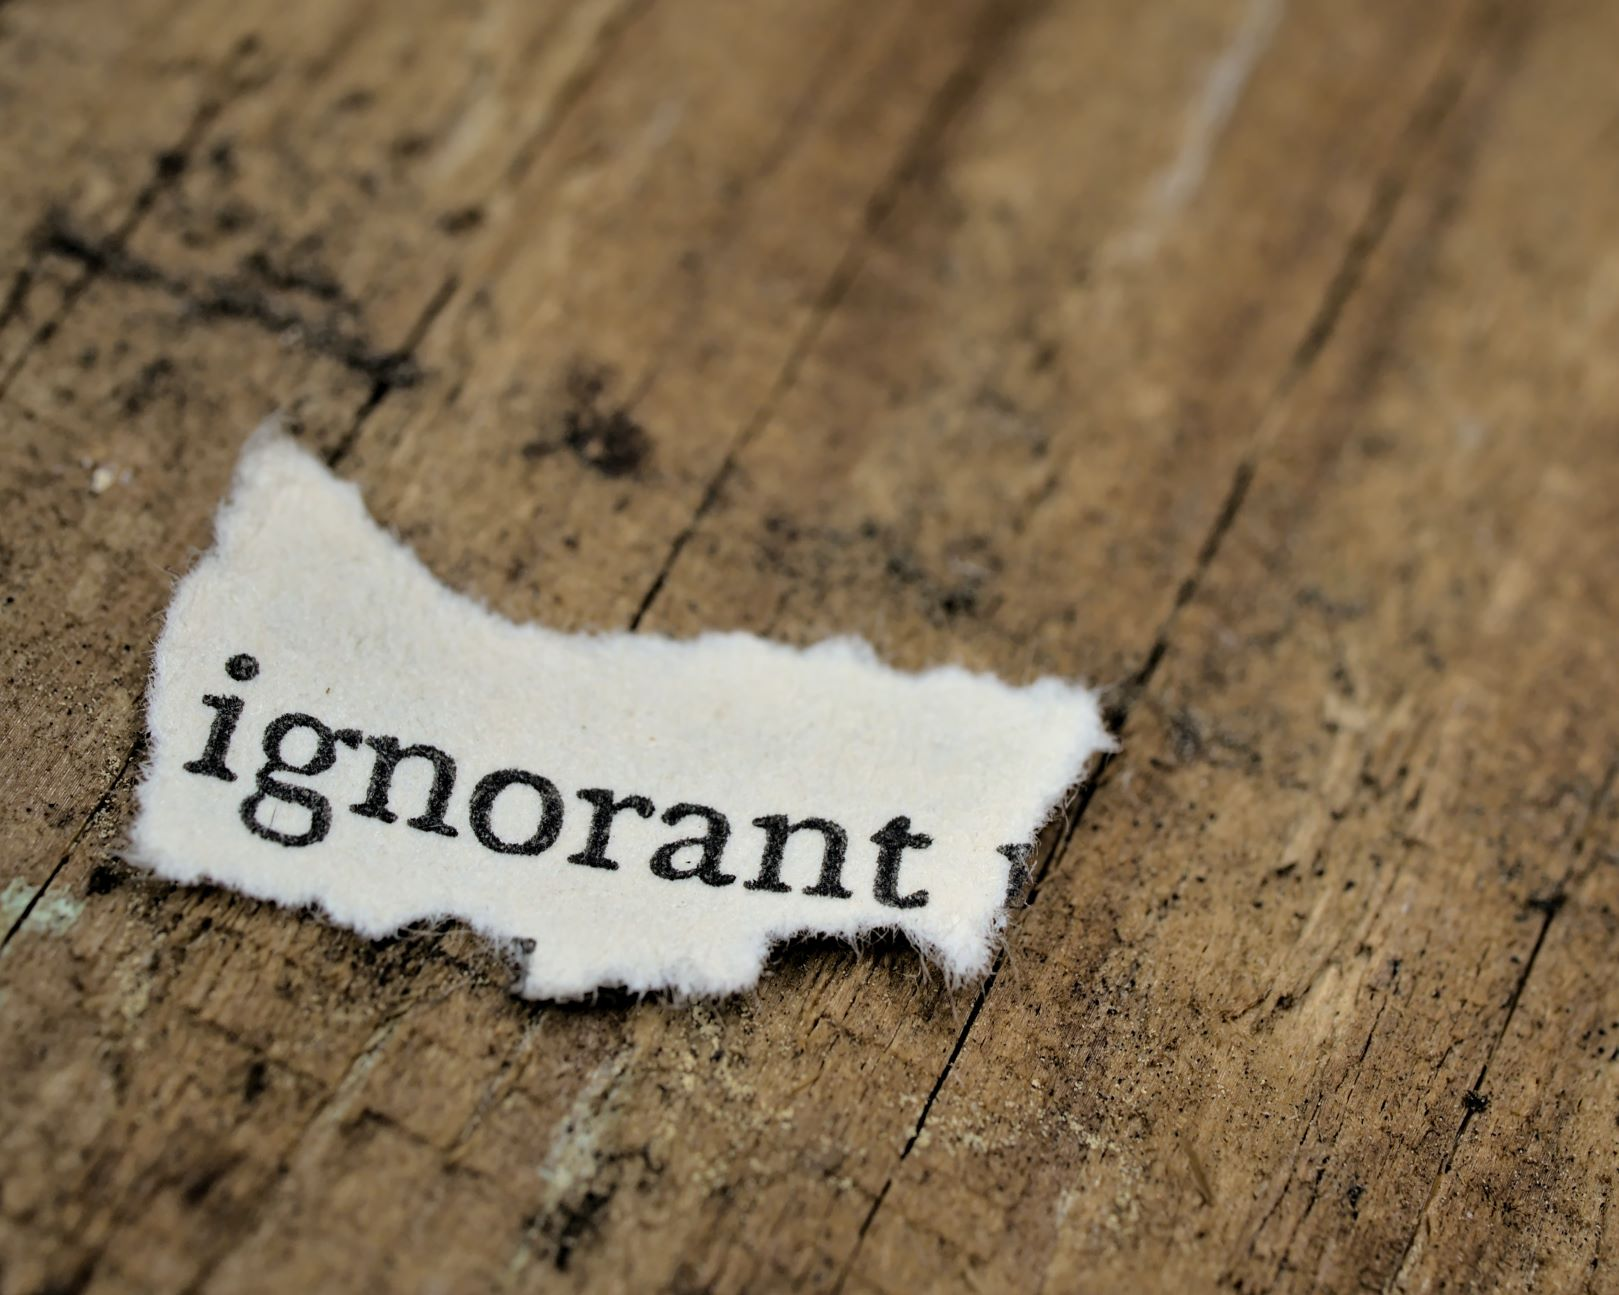

Photo Credit: https://unsplash.com/

### Import Libraries

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Loading Data

In [27]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip').fillna(' ')

# Here is a sample of the data
train_df.sample(10, random_state = 1234)

In [28]:
# Show the comments
x = train_df['comment_text'].values 
print(x)

In [29]:
# View 10 random toxic comments
train_df.loc[train_df['toxic'] == 1].sample(10, random_state=1234)

In [30]:
# Create and generate a WordCloud image with toxic comments
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))

# Display the generated image
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show() 

In [31]:
y = train_df['toxic'].values
print(y)

In [32]:
# Plot frequency of toxic comments (0 = not toxic, 1 = toxic)
green = '#52BE80'
red = '#EC7063'

plt.figure(figsize=(12,8))
ax = sns.countplot(train_df['toxic'], palette=[green, red]) 
ax.set_title('Distribution of toxic comments')
ax.set_ylabel('Samples');

In [33]:
# Counts of comments (0 = not toxic, 1 = toxic)
train_df['toxic'].value_counts()

In [34]:
# Number of carachters in comments
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
comment_len=train_df[train_df['toxic']==1]['comment_text'].str.len()
ax1.hist(comment_len,color=red)
ax1.set_title('Toxic comments')

comment_len=train_df[train_df['toxic']==0]['comment_text'].str.len()
ax2.hist(comment_len,color=green)
ax2.set_title('Not toxic comments')
fig.suptitle('Characters in comments')
plt.show()

The distribution of both seems to be almost same. Until 500 characters in a comment are the most common among both.

In [35]:
# Number of words in a comment
fig,(ax1,ax2)=plt.subplots(1,2,figsize = (12,8))
comment_len=train_df[train_df['toxic']==1]['comment_text'].str.split().map(lambda x: len(x))
ax1.hist(comment_len,color = red)
ax1.set_title('Toxic Comments')

comment_len=train_df[train_df['toxic']==0]['comment_text'].str.split().map(lambda x: len(x))
ax2.hist(comment_len,color = green)
ax2.set_title('Not toxic comments')
fig.suptitle('Words in a comment')
plt.show()

### Tokenization and Text Data Preparation 

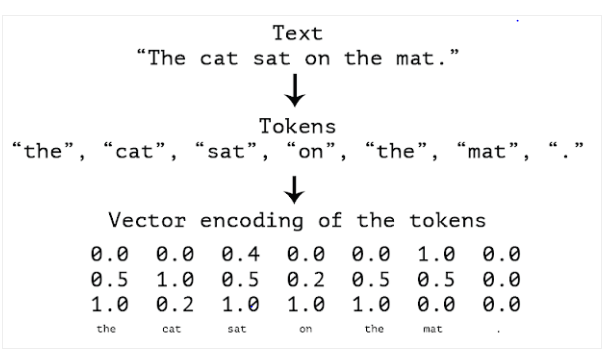

Source: https://freecontent.manning.com/deep-learning-for-text/

In [36]:
# Define some hyperparameters for performing tokenization
max_features = 20000 
max_text_length = 100

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

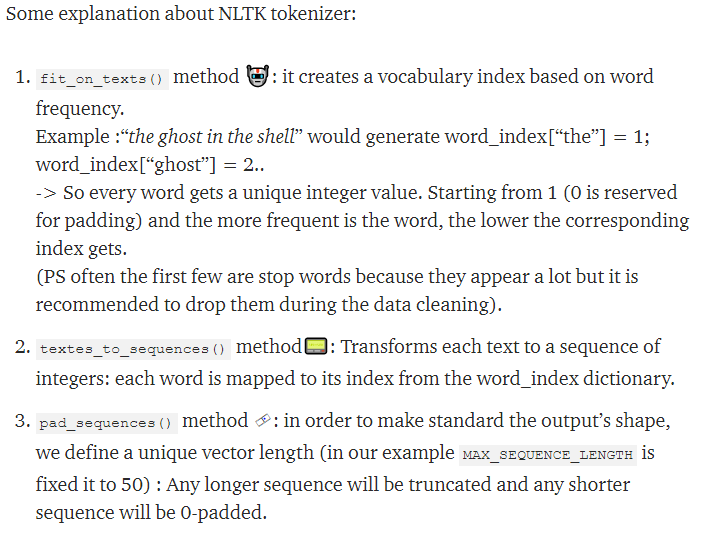

Source: https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

### Prepare Embedding Matrix with Pre-trained GloVe (Global Vectors) Embeddings

TensorFlow enables to train word embeddings. However, this process not only requires a lot of data but can also be time and resource-intensive. 
To tackle these challenges we'll use pre-trained word embeddings. 

The first step is to obtain the word embedding and append them to a dictionary. After that, we'll need to create an embedding matrix for each word in the training set. 

Let's start by downloading the GloVe word embeddings. After that is to create that dictionary with those embeddings. Let's work with the glove.6B.100d.tx embeddings. The 100 in the name is the same as the maximum length chosen for the sequences.The next step is to create a word embedding matrix for each word in the word index that was obtained earlier. If a word doesn't have an embedding in GloVe it will be presented with a zero matrix.

In [37]:
embedding_dim = 100
embeddings_index = dict()

f = open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Then we will create an embedding matrix that maps each word index to its corresponding embedding vector:

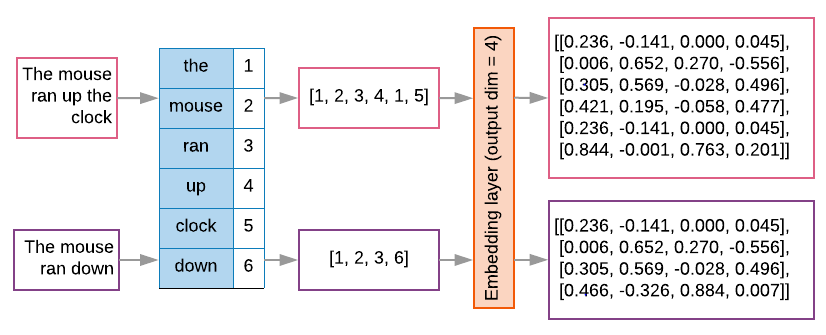

Source: https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png

In [38]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [39]:
# Here is what the word embedding for the word 'stop' looks like
embeddings_index.get('stop')

### Create the Embedding Layer 

In [40]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix), trainable=False))
model.add(Dropout(0.2))

### Build the Model

In [41]:
# Define parameters
filters = 150
kernel_size = 3
hidden_dims = 150

In [42]:
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

# Display the model structure
model.summary()

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training Model

In [44]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size = 0.30, random_state = 1235)

In [45]:
# Train the model, iterating on the data in batches of 64 samples
%time
batch_size = 64
epochs = 10

model.fit(x_train, y_train, batch_size = batch_size,
          epochs = epochs, validation_data=(x_val, y_val))

### Evaluation Model

In [46]:
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

x_test = test_df['comment_text'].values
print(x_test)

In [47]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

y_testing = model.predict(x_testing, verbose=1, batch_size=64)

In [48]:
y_testing.shape

In [49]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(10) 

### 👍 ❤️ If you find this notebook useful, I would appreciate an upvote! ❤️ 👍
